In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

/var/folders/h_/r3lv2bc576qbm4jbyp94hfxr0000gn/T/ipykernel_6845/3380814242.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df_raw.replace(',', '.', regex=True).astype(float)


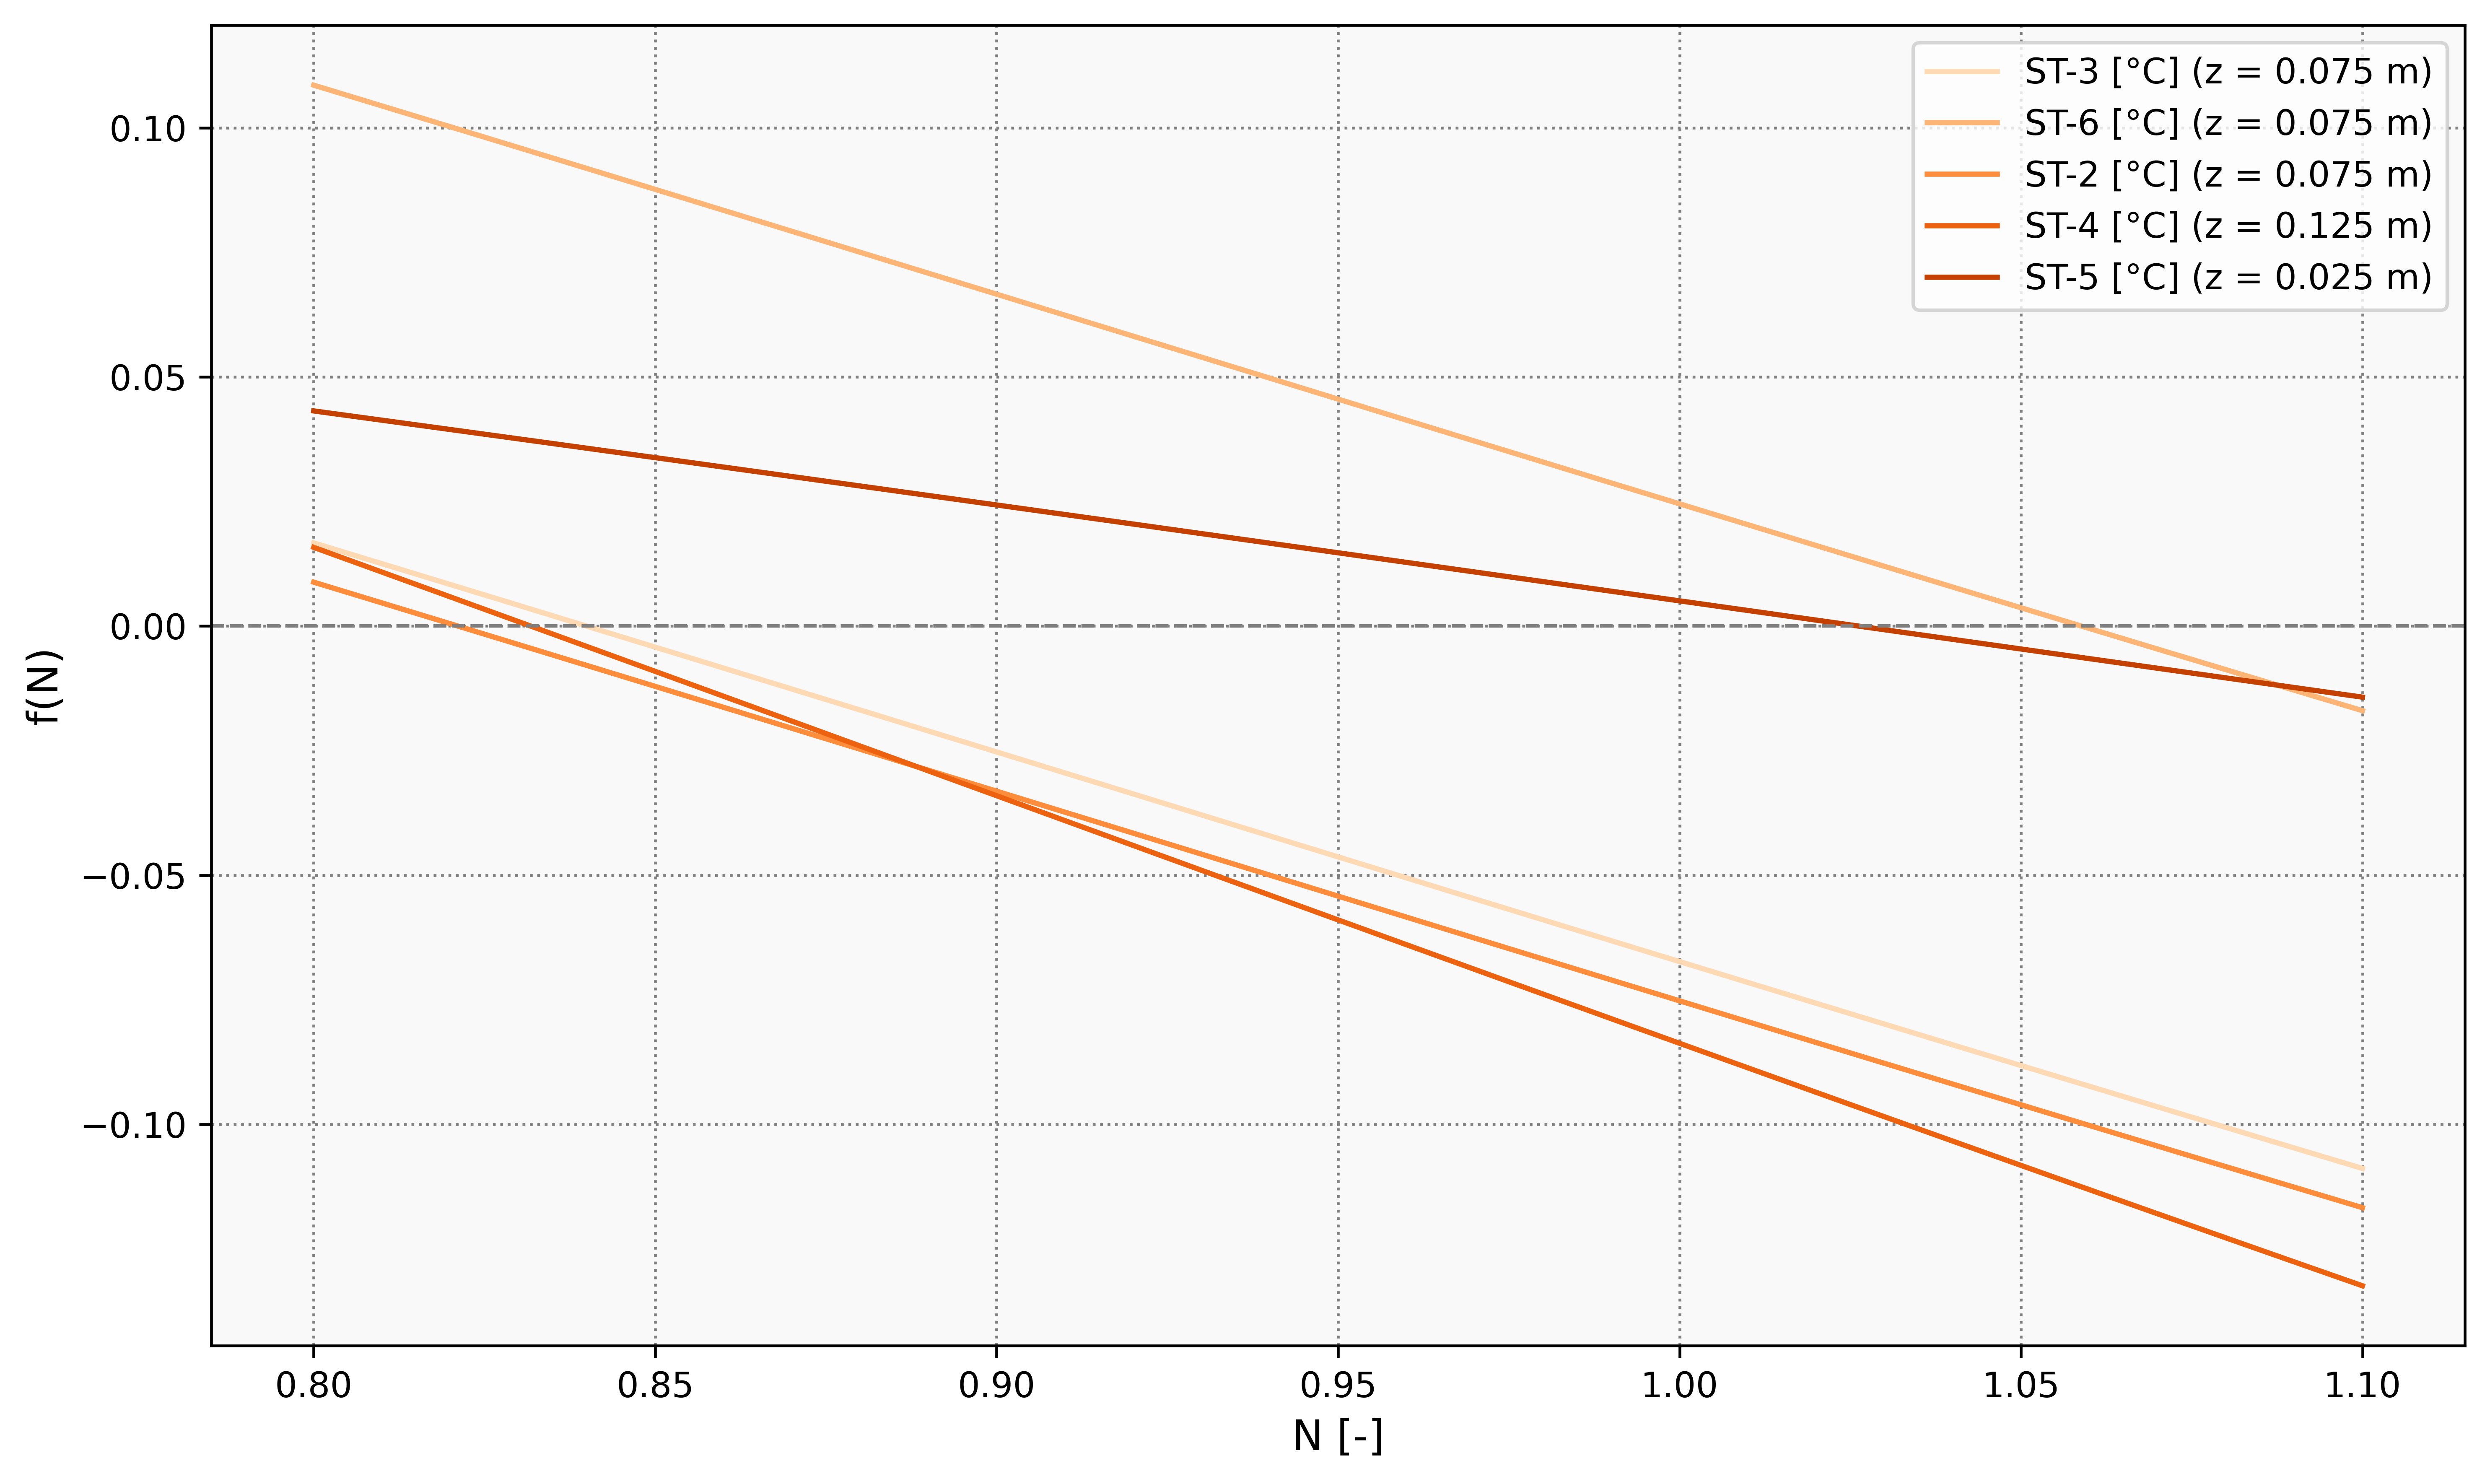

      Sensor  z [m]  Theta_exp      zeta         N  h [W/m²·K]   η [-]
0  ST-3 [°C]  0.075   0.774278  0.576923  0.839875        8.77  0.8165
1  ST-6 [°C]  0.075   0.682415  0.576923  1.058793       13.93  0.7416
2  ST-2 [°C]  0.075   0.782152  0.576923  0.821065        8.38  0.8229
3  ST-4 [°C]  0.125   0.732283  0.961538  0.831727        8.60  0.8193
4  ST-5 [°C]  0.025   0.866142  0.192308  1.026080       13.08  0.7527

Average heat transfer coefficient 25% h_avg = 10.55 W/m²·K


In [49]:
# === Constants ===
L = 0.130  # Fin length [m]
positions = {
    'ST-3 [°C]': 0.075,
    'ST-6 [°C]': 0.075,
    'ST-2 [°C]': 0.075,
    'ST-4 [°C]': 0.125,
    'ST-5 [°C]': 0.025
}

B = 0.002 / 2  # Half-thickness [m]
k = 210        # Thermal conductivity [W/m·K]

# === Load Excel file ===
file_path = '/Users/ludovica/Documents/Bachelor/BA6/TP GC/TP 8 /Data TP8.xlsx'
sheet_name = 'fan 25'

# Read Excel, skip metadata row, use openpyxl engine
df_raw = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=1, engine='openpyxl')
df_raw = df_raw.iloc[:-1]  # Skip footer row manually


# Replace comma decimal separators and convert to float
df = df_raw.replace(',', '.', regex=True).astype(float)

# Rename columns to standardize °C symbol
df.columns = [col.replace('∞C', '°C') for col in df.columns]

# === Steady-state index ===
idx = df.index[-1]
T_inf = df['ST-7 [°C]'][idx]
T_w = df['ST-cont [°C]'][idx]

# === Define functions ===
def f_N(N, Theta_exp, zeta):
    return np.cosh(N * (1 - zeta)) / np.cosh(N) - Theta_exp

def secant_method(f, x0, x1, tol=1e-12, max_iter=100):
    f0 = f(x0)
    f1 = f(x1)
    for _ in range(max_iter):
        if abs(f1 - f0) < 1e-14:
            break
        x_new = x1 - f1 * (x1 - x0) / (f1 - f0)
        f_new = f(x_new)
        if abs(f_new) < tol:
            return x_new
        x0, f0 = x1, f1
        x1, f1 = x_new, f_new
    return x1

# === Loop over sensors ===
results = []

# Create orange gradient
num_positions = len(positions)
colors = cm.Oranges(np.linspace(0.2, 0.8, num_positions))


plt.figure(1, figsize=(10, 6), dpi=600)

for i, (col, z) in enumerate(positions.items()):
    T_z = df[col][idx]
    Theta_exp = (T_z - T_inf) / (T_w - T_inf)
    zeta = z / L

    # Define function for current zeta and Theta
    f_lambda = lambda N: f_N(N, Theta_exp, zeta)

    # Find N using secant method
    N_sol = secant_method(f_lambda, 1.9, 2.0)

    # Compute h and effectiveness
    h = k * B * N_sol**2 / L**2
    eta = np.tanh(N_sol) / N_sol

    # Save results
    results.append({
        'Sensor': col,
        'z [m]': z,
        'Theta_exp': Theta_exp,
        'zeta': zeta,
        'N': N_sol,
        'h [W/m²·K]': h,
        'η [-]': eta
    })

    # Plot f(N)
    N_range = np.linspace(0.8, 1.1, 600)
    y_vals = [f_lambda(N) for N in N_range]
    plt.plot(N_range, y_vals, label=f'{col} (z = {z:.3f} m)', color=colors[i])



# === Plot details ===

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('N [-]', fontsize=12)
plt.ylabel('f(N)', fontsize=12)
plt.legend()
plt.gca().set_facecolor('#f9f9f9')
plt.grid(True, linestyle=':', which='both', axis='both', color='gray')
plt.tight_layout()
save_path = os.path.join('/Users/ludovica/Documents/Bachelor/BA6/TP GC/TP 8 ', "fan_h_25.png")
plt.savefig(save_path, format='png', bbox_inches='tight')
plt.show()

# === Show results ===
df_results = pd.DataFrame(results)
df_results['h [W/m²·K]'] = df_results['h [W/m²·K]'].round(2)
df_results['η [-]'] = df_results['η [-]'].round(4)
df_results['N'] = df_results['N'].round(6)

print(df_results)

# === Average h ===
avg_h = df_results['h [W/m²·K]'].mean()
print(f"\nAverage heat transfer coefficient 25% h_avg = {avg_h:.2f} W/m²·K")



/var/folders/h_/r3lv2bc576qbm4jbyp94hfxr0000gn/T/ipykernel_6845/4156895539.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df_raw.replace(',', '.', regex=True).astype(float)


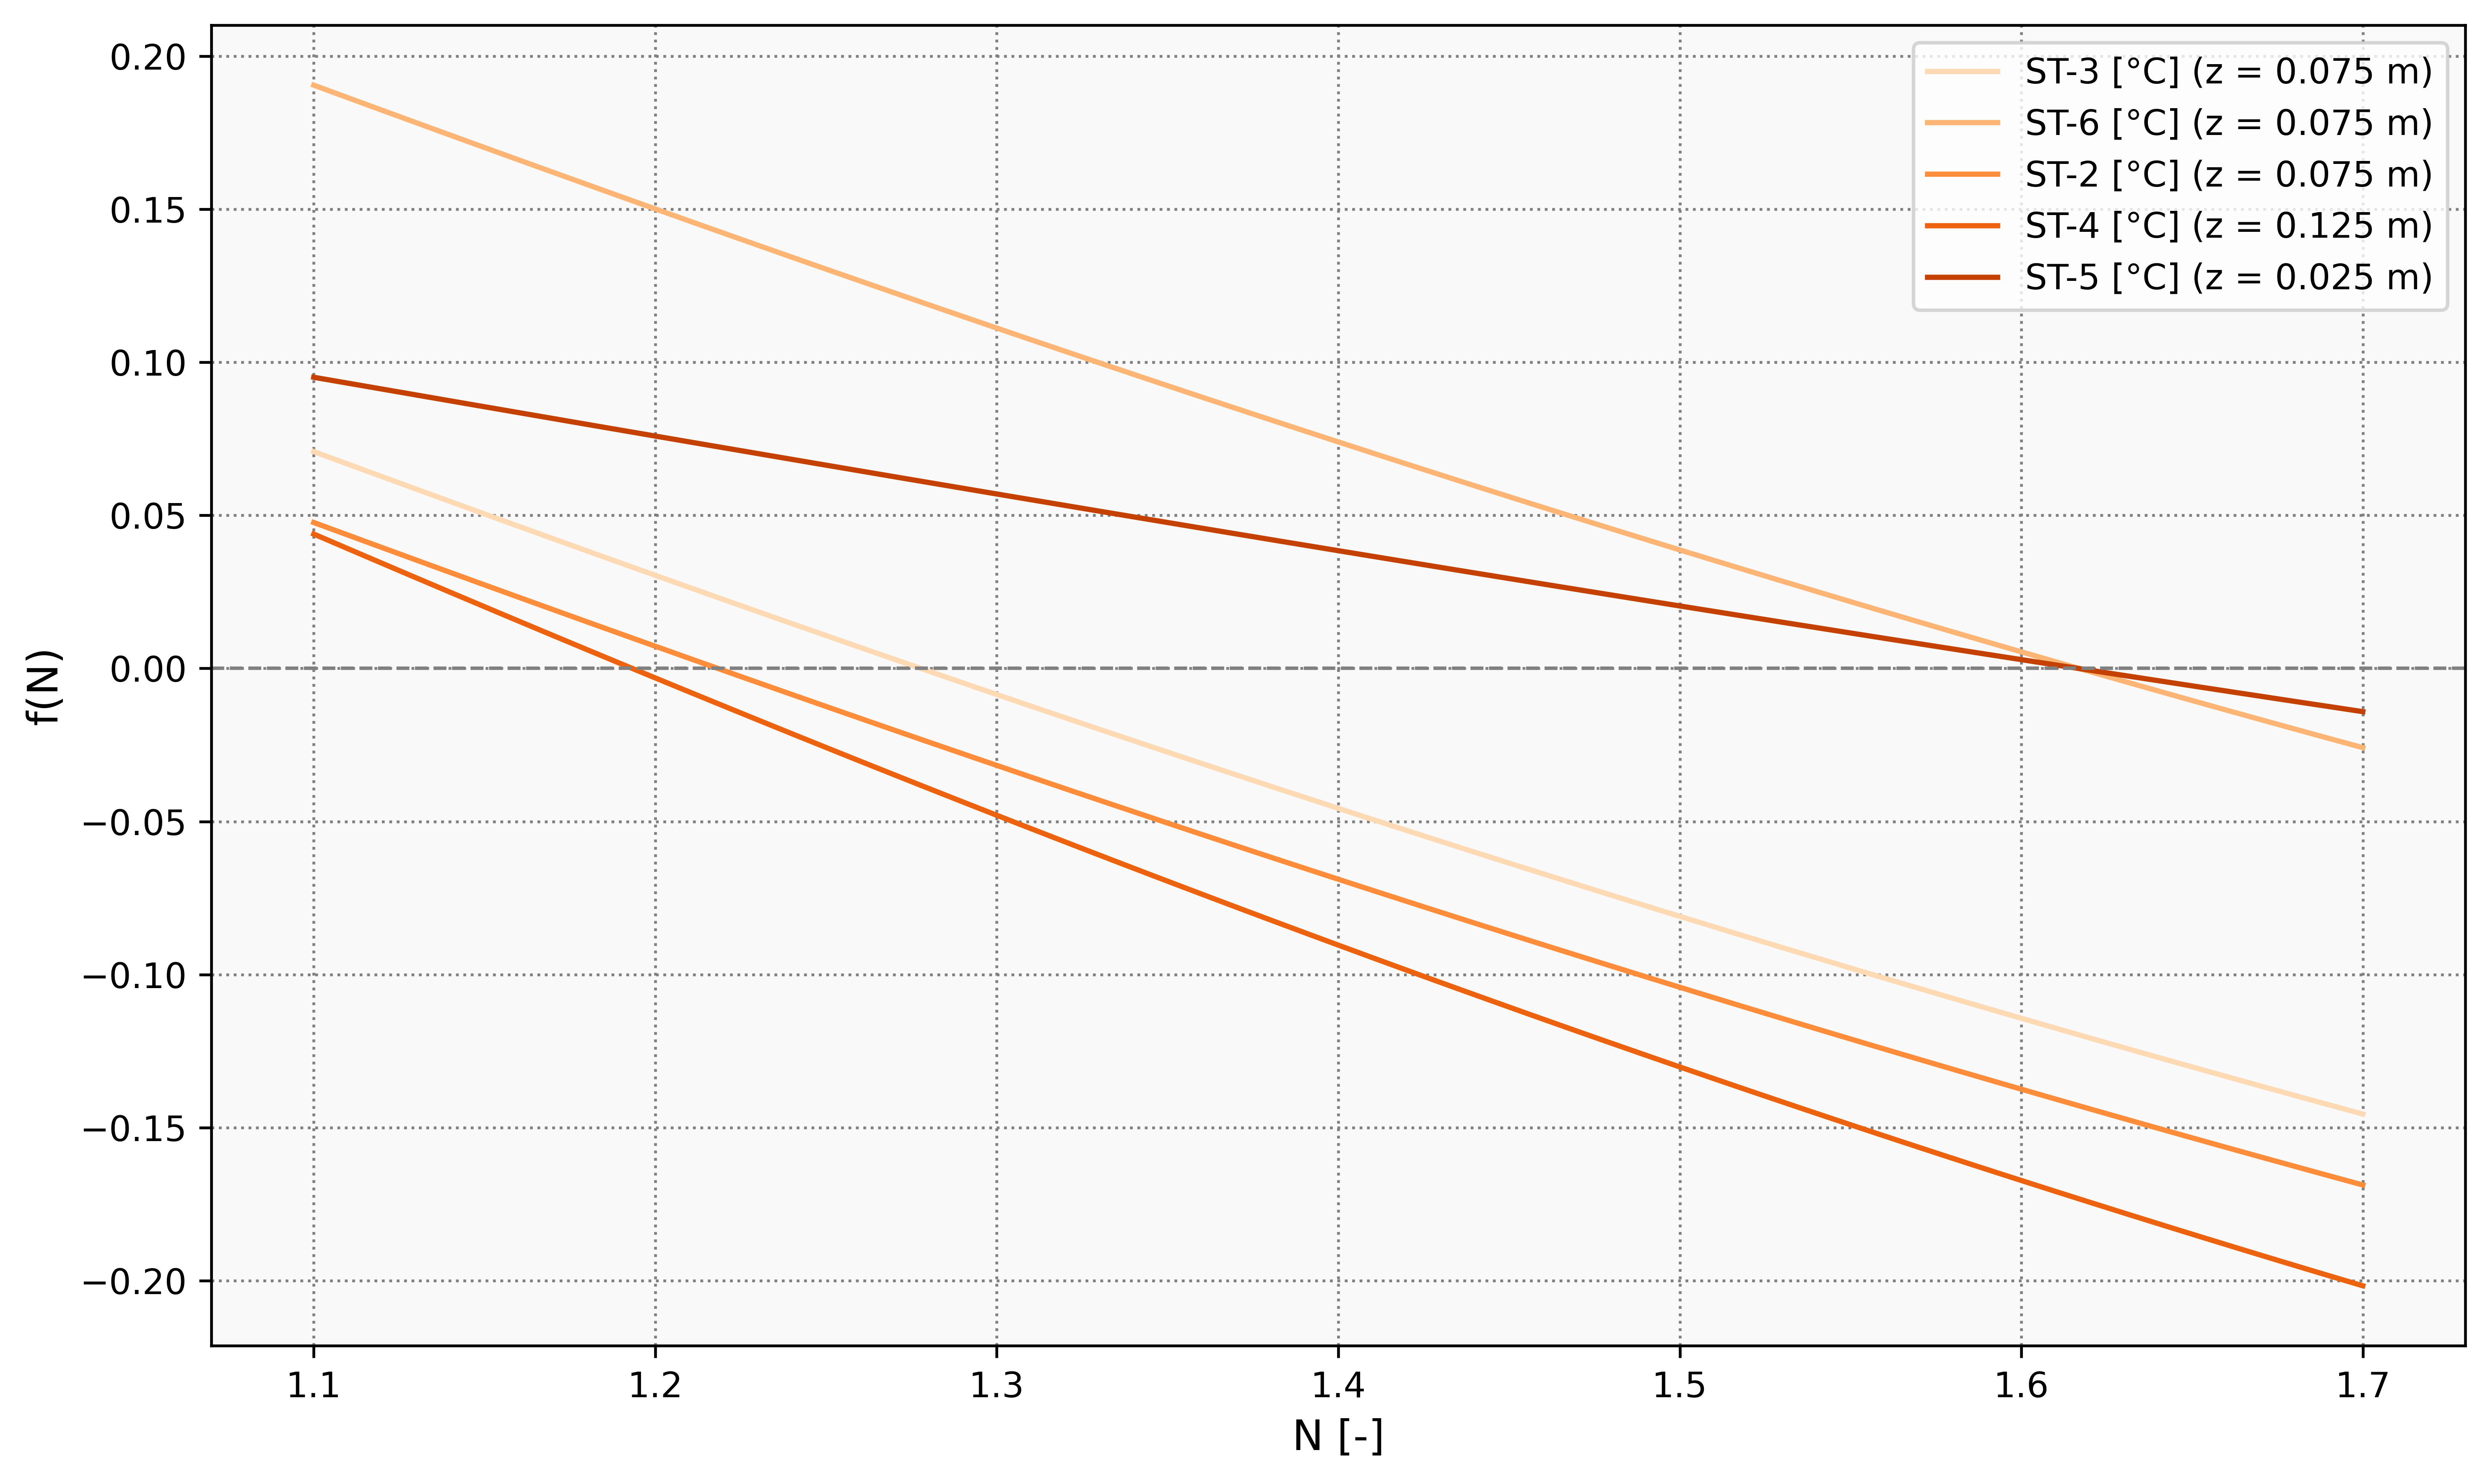

      Sensor  z [m]  Theta_exp      zeta         N  h [W/m²·K]   η [-]
0  ST-3 [°C]  0.075   0.594595  0.576923  1.277745       20.29  0.6698
1  ST-6 [°C]  0.075   0.474903  0.576923  1.616849       32.48  0.5716
2  ST-2 [°C]  0.075   0.617761  0.576923  1.218299       18.44  0.6888
3  ST-4 [°C]  0.125   0.555985  0.961538  1.193248       17.69  0.6969
4  ST-5 [°C]  0.025   0.756757  0.192308  1.616661       32.48  0.5716

Average heat transfer coefficient 25% h_avg = 24.28 W/m²·K


In [50]:
# === Constants ===
L = 0.130  # Fin length [m]
positions = {
    'ST-3 [°C]': 0.075,
    'ST-6 [°C]': 0.075,
    'ST-2 [°C]': 0.075,
    'ST-4 [°C]': 0.125,
    'ST-5 [°C]': 0.025
}

B = 0.002 / 2  # Half-thickness [m]
k = 210        # Thermal conductivity [W/m·K]

# === Load Excel file ===
file_path = '/Users/ludovica/Documents/Bachelor/BA6/TP GC/TP 8 /Data TP8.xlsx'
sheet_name = 'fan 50'

# Read Excel, skip metadata row, use openpyxl engine
df_raw = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=1, engine='openpyxl')
df_raw = df_raw.iloc[:-1]  # Skip footer row manually


# Replace comma decimal separators and convert to float
df = df_raw.replace(',', '.', regex=True).astype(float)

# Rename columns to standardize °C symbol
df.columns = [col.replace('∞C', '°C') for col in df.columns]

# === Steady-state index ===
idx = df.index[-1]
T_inf = df['ST-7 [°C]'][idx]
T_w = df['ST-cont [°C]'][idx]

# === Define functions ===
def f_N(N, Theta_exp, zeta):
    return np.cosh(N * (1 - zeta)) / np.cosh(N) - Theta_exp

def secant_method(f, x0, x1, tol=1e-12, max_iter=100):
    f0 = f(x0)
    f1 = f(x1)
    for _ in range(max_iter):
        if abs(f1 - f0) < 1e-14:
            break
        x_new = x1 - f1 * (x1 - x0) / (f1 - f0)
        f_new = f(x_new)
        if abs(f_new) < tol:
            return x_new
        x0, f0 = x1, f1
        x1, f1 = x_new, f_new
    return x1

# === Loop over sensors ===
results = []

# Create orange gradient
num_positions = len(positions)
colors = cm.Oranges(np.linspace(0.2, 0.8, num_positions))


plt.figure(1, figsize=(10, 6), dpi=600)

for i, (col, z) in enumerate(positions.items()):
    T_z = df[col][idx]
    Theta_exp = (T_z - T_inf) / (T_w - T_inf)
    zeta = z / L

    # Define function for current zeta and Theta
    f_lambda = lambda N: f_N(N, Theta_exp, zeta)

    # Find N using secant method
    N_sol = secant_method(f_lambda, 1.9, 2.0)

    # Compute h and effectiveness
    h = k * B * N_sol**2 / L**2
    eta = np.tanh(N_sol) / N_sol

    # Save results
    results.append({
        'Sensor': col,
        'z [m]': z,
        'Theta_exp': Theta_exp,
        'zeta': zeta,
        'N': N_sol,
        'h [W/m²·K]': h,
        'η [-]': eta
    })

    # Plot f(N)
    N_range = np.linspace(1.1, 1.7, 600)
    y_vals = [f_lambda(N) for N in N_range]
    plt.plot(N_range, y_vals, label=f'{col} (z = {z:.3f} m)', color=colors[i])



# === Plot details ===

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('N [-]', fontsize=12)
plt.ylabel('f(N)', fontsize=12)
plt.legend()
plt.gca().set_facecolor('#f9f9f9')
plt.grid(True, linestyle=':', which='both', axis='both', color='gray')
plt.tight_layout()
save_path = os.path.join('/Users/ludovica/Documents/Bachelor/BA6/TP GC/TP 8 ', "fan_h_50.png")
plt.savefig(save_path, format='png', bbox_inches='tight')
plt.show()

# === Show results ===
df_results = pd.DataFrame(results)
df_results['h [W/m²·K]'] = df_results['h [W/m²·K]'].round(2)
df_results['η [-]'] = df_results['η [-]'].round(4)
df_results['N'] = df_results['N'].round(6)

print(df_results)

# === Average h ===
avg_h = df_results['h [W/m²·K]'].mean()
print(f"\nAverage heat transfer coefficient 25% h_avg = {avg_h:.2f} W/m²·K")



/var/folders/h_/r3lv2bc576qbm4jbyp94hfxr0000gn/T/ipykernel_6845/3918027612.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df_raw.replace(',', '.', regex=True).astype(float)


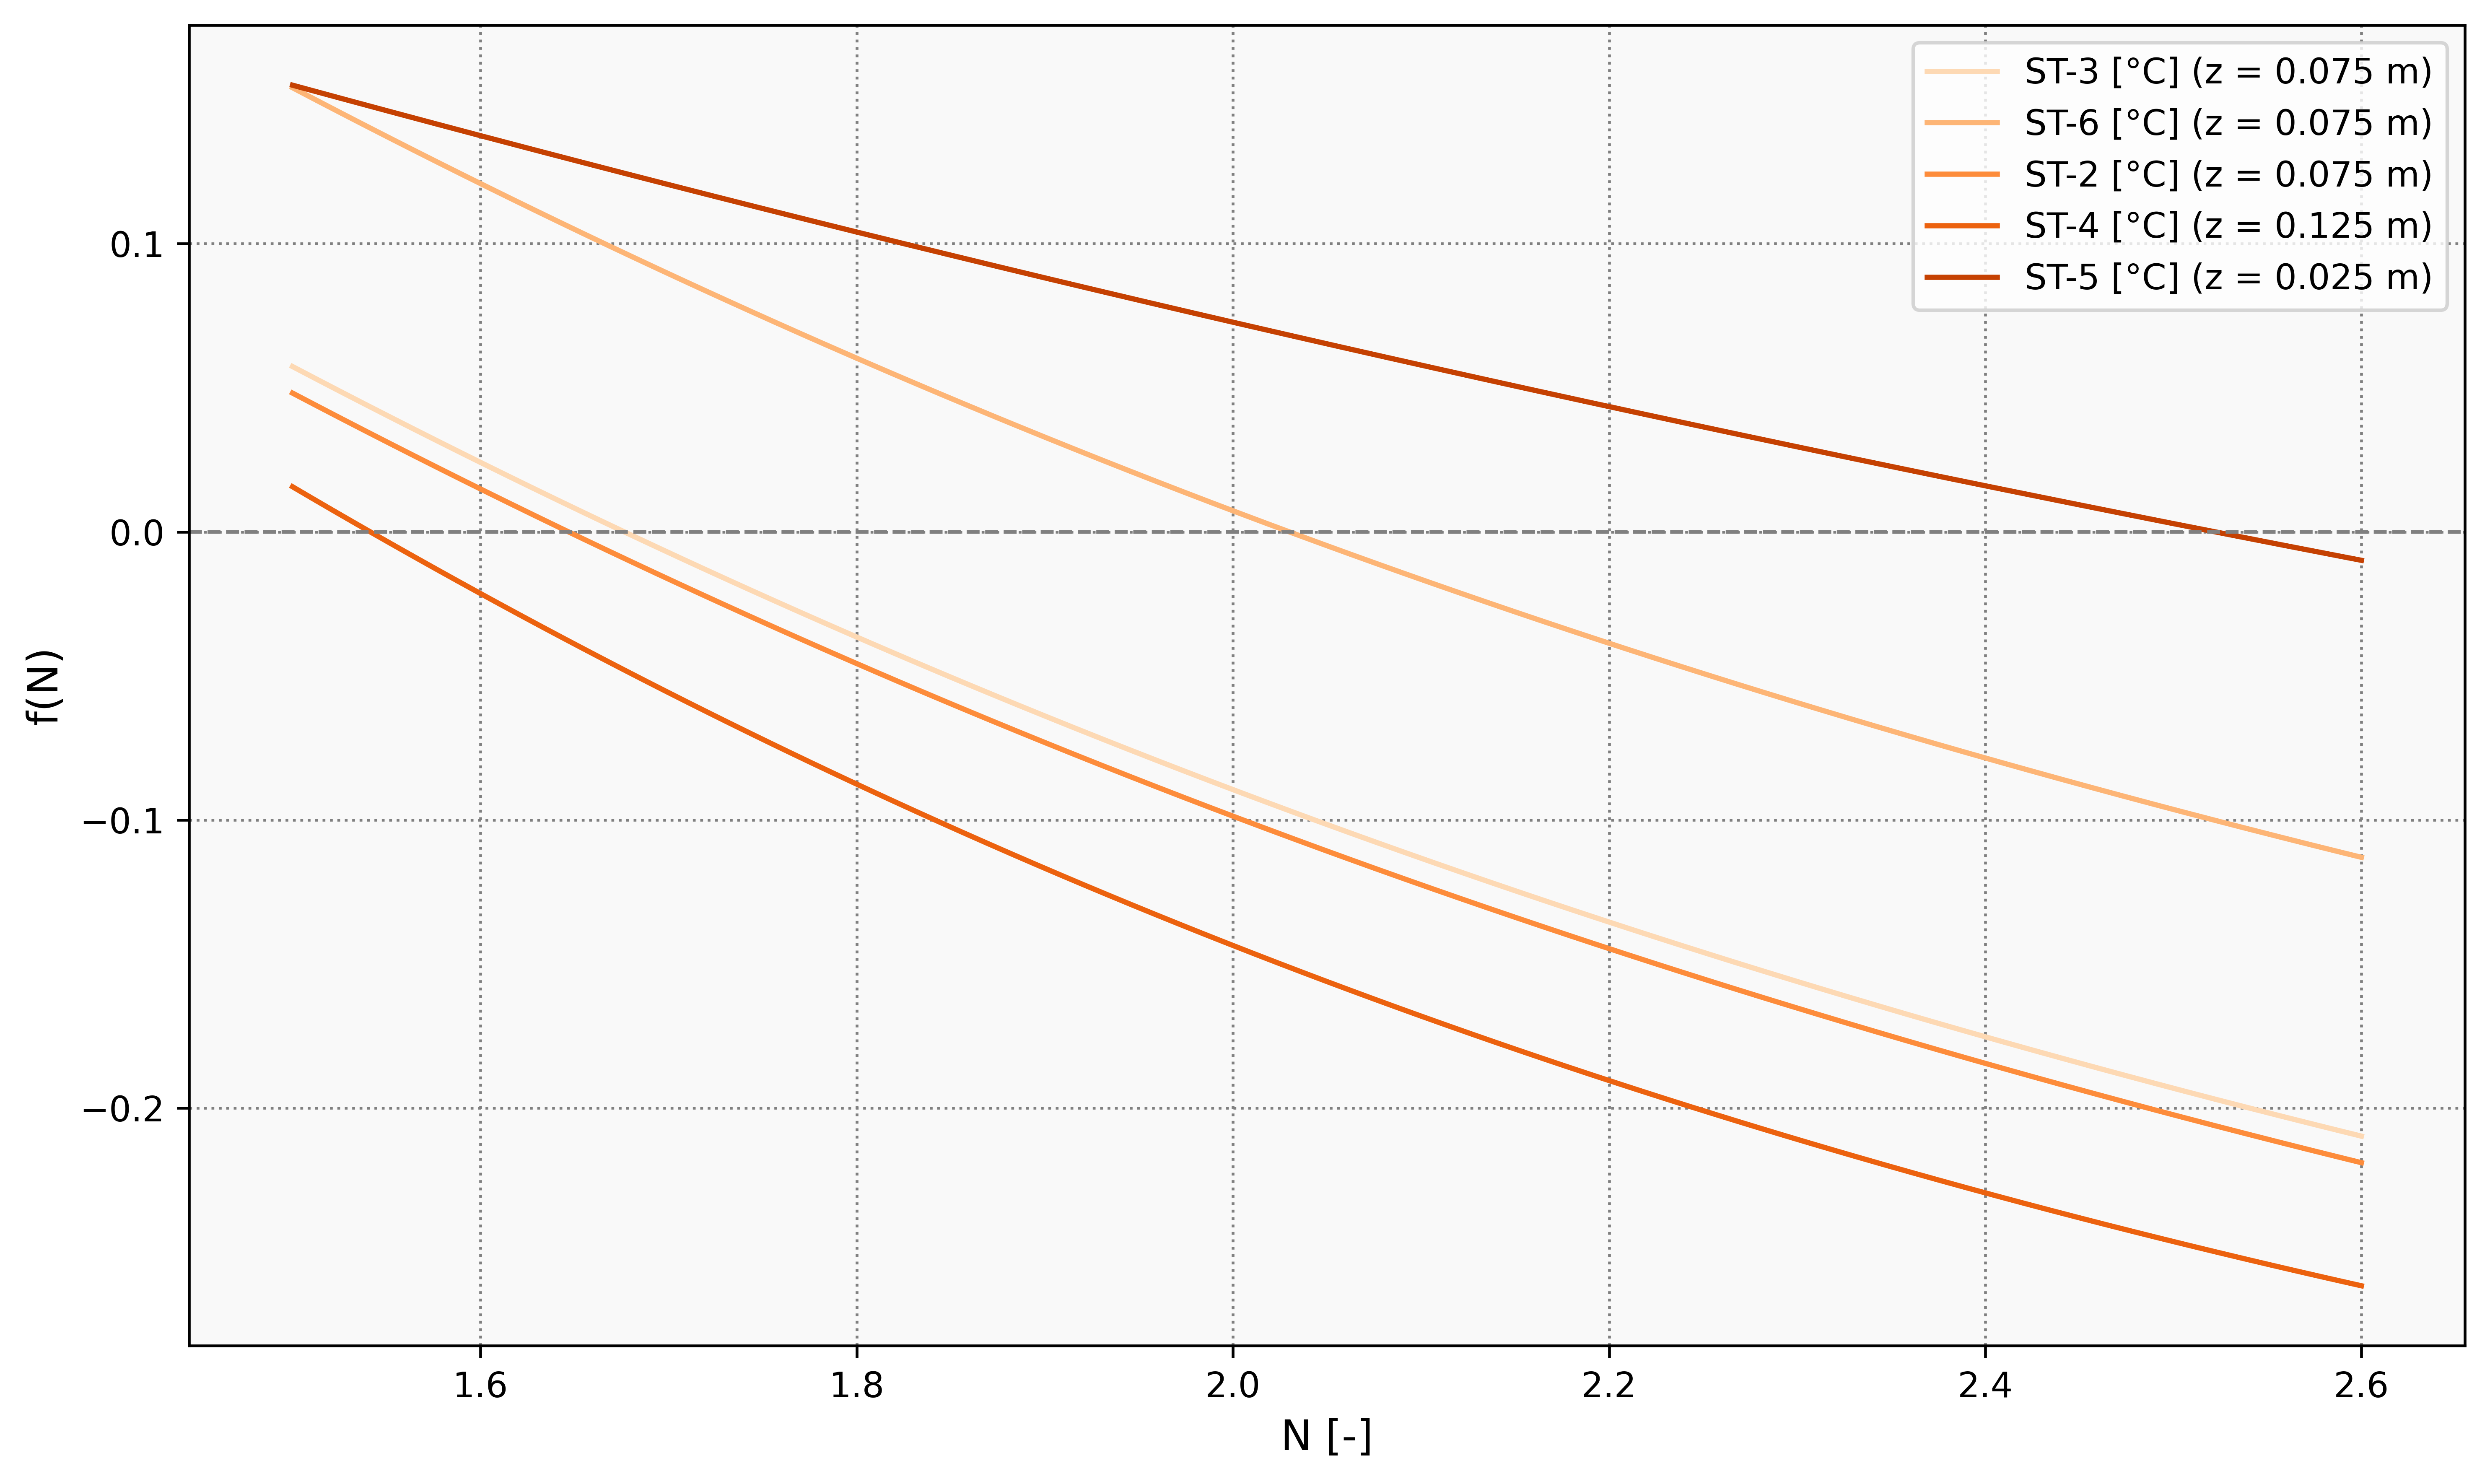

      Sensor  z [m]  Theta_exp      zeta         N  h [W/m²·K]   η [-]
0  ST-3 [°C]  0.075   0.456221  0.576923  1.676432       34.92  0.5562
1  ST-6 [°C]  0.075   0.359447  0.576923  2.030009       51.21  0.4759
2  ST-2 [°C]  0.075   0.465438  0.576923  1.646755       33.70  0.5638
3  ST-4 [°C]  0.125   0.410138  0.961538  1.541348       29.52  0.5919
4  ST-5 [°C]  0.025   0.622120  0.192308  2.522298       79.05  0.3914

Average heat transfer coefficient 25% h_avg = 45.68 W/m²·K


In [51]:
# === Constants ===
L = 0.130  # Fin length [m]
positions = {
    'ST-3 [°C]': 0.075,
    'ST-6 [°C]': 0.075,
    'ST-2 [°C]': 0.075,
    'ST-4 [°C]': 0.125,
    'ST-5 [°C]': 0.025
}

B = 0.002 / 2  # Half-thickness [m]
k = 210        # Thermal conductivity [W/m·K]

# === Load Excel file ===
file_path = '/Users/ludovica/Documents/Bachelor/BA6/TP GC/TP 8 /Data TP8.xlsx'
sheet_name = 'fan 75'

# Read Excel, skip metadata row, use openpyxl engine
df_raw = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=1, engine='openpyxl')
df_raw = df_raw.iloc[:-1]  # Skip footer row manually


# Replace comma decimal separators and convert to float
df = df_raw.replace(',', '.', regex=True).astype(float)

# Rename columns to standardize °C symbol
df.columns = [col.replace('∞C', '°C') for col in df.columns]

# === Steady-state index ===
idx = df.index[-1]
T_inf = df['ST-7 [°C]'][idx]
T_w = df['ST-cont [°C]'][idx]

# === Define functions ===
def f_N(N, Theta_exp, zeta):
    return np.cosh(N * (1 - zeta)) / np.cosh(N) - Theta_exp

def secant_method(f, x0, x1, tol=1e-12, max_iter=100):
    f0 = f(x0)
    f1 = f(x1)
    for _ in range(max_iter):
        if abs(f1 - f0) < 1e-14:
            break
        x_new = x1 - f1 * (x1 - x0) / (f1 - f0)
        f_new = f(x_new)
        if abs(f_new) < tol:
            return x_new
        x0, f0 = x1, f1
        x1, f1 = x_new, f_new
    return x1

# === Loop over sensors ===
results = []

num_positions = len(positions)
colors = cm.Oranges(np.linspace(0.2, 0.8, num_positions))

plt.figure(1, figsize=(10, 6), dpi=600)

for i, (col, z) in enumerate(positions.items()):
    T_z = df[col][idx]
    Theta_exp = (T_z - T_inf) / (T_w - T_inf)
    zeta = z / L

    # Define function for current zeta and Theta
    f_lambda = lambda N: f_N(N, Theta_exp, zeta)

    # Find N using secant method
    N_sol = secant_method(f_lambda, 1.9, 2.0)

    # Compute h and effectiveness
    h = k * B * N_sol**2 / L**2
    eta = np.tanh(N_sol) / N_sol

    # Save results
    results.append({
        'Sensor': col,
        'z [m]': z,
        'Theta_exp': Theta_exp,
        'zeta': zeta,
        'N': N_sol,
        'h [W/m²·K]': h,
        'η [-]': eta
    })

    # Plot f(N)
    N_range = np.linspace(1.5, 2.6, 600)
    y_vals = [f_lambda(N) for N in N_range]
    plt.plot(N_range, y_vals, label=f'{col} (z = {z:.3f} m)', color=colors[i])



# === Plot details ===

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('N [-]', fontsize=12)
plt.ylabel('f(N)', fontsize=12)
plt.legend()
plt.gca().set_facecolor('#f9f9f9')
plt.grid(True, linestyle=':', which='both', axis='both', color='gray')
plt.tight_layout()
save_path = os.path.join('/Users/ludovica/Documents/Bachelor/BA6/TP GC/TP 8 ', "fan_h_75.png")
plt.savefig(save_path, format='png', bbox_inches='tight')
plt.show()

# === Show results ===
df_results = pd.DataFrame(results)
df_results['h [W/m²·K]'] = df_results['h [W/m²·K]'].round(2)
df_results['η [-]'] = df_results['η [-]'].round(4)
df_results['N'] = df_results['N'].round(6)

print(df_results)

# === Average h ===
avg_h = df_results['h [W/m²·K]'].mean()
print(f"\nAverage heat transfer coefficient 25% h_avg = {avg_h:.2f} W/m²·K")

